### Import Libraries

In [1]:
"If it does not work use code below while running this notebook in this dir."
import sys
import os
# sys.path.append(os.path.abspath(os.getcwd()))
sys.path.append(os.path.abspath(os.getcwd() + "\\Desktop\\CIHW"))

%load_ext autoreload


%autoreload 2
from mytorch import Tensor, Model, Dependency
%autoreload 2
from mytorch import activation as active_func
%autoreload 2
from mytorch import loss as loss_func
%autoreload 2
from mytorch import optimizer as optim 
%autoreload 2
from mytorch import layer as nn
%autoreload 2
from mytorch.util import DataLoader
%autoreload 2
from mytorch.util import flatten

import numpy as np
import matplotlib.pyplot as plt

### Load MNIST

In [2]:
"""
load data set with given data loader.
you have 10000 train data, 1000 for each number, remember to shuffle training data.
you have 1000 test data, 100 for each number.

loaded data is a list of (img, label)
type of img is Tensor.

TODO: you have to get this list and create batches for training.
you can also apply this changes later in the Training part for convenience.
"""
data_loader = DataLoader(train_addr='MNIST/train', test_addr='MNIST/test')
data_loader.load(100, 20)
"you can see how data is loaded"
print(len(data_loader.getTrain()))
print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...
50
(200,)


### Define and Create your Model

In [ ]:
def reshape(x:Tensor, shape) -> Tensor:
    data = x.data.reshape(*shape)
    req_grad = x.requires_grad
    if req_grad:
        def grad_fn(grad: np.ndarray) -> np.ndarray:
            # print("reshape grad")
            return grad.reshape(*x.shape)
        depends_on = [Dependency(x, grad_fn)]
    else:
        depends_on = []
    return Tensor(data=data, requires_grad=req_grad, depends_on=depends_on)


def reshape_labels(labels: Tensor) -> Tensor:
    newData = np.zeros((labels.shape[0], 10))
    for i, initial_value in enumerate(labels.data):
        newData[i, initial_value] = 1
    return Tensor(newData, labels.requires_grad, labels.depends_on)

def normalize_images(images: Tensor) -> Tensor:
    images.data = images.data / 200.0

In [3]:
def reshape(x: Tensor, newShape) -> Tensor:
    data = x.data.reshape(newShape)
    req_grad =x.requires_grad
    depends_on = x.depends_on
    return Tensor(data=data, requires_grad=req_grad, depends_on=depends_on)

In [4]:
class MyModel(Model):
    def __init__(self):
        "TODO: define your layers. order is important"
        self.conv1 = nn.Conv2d(1,8,kernel_size = (4,4), padding = None, need_bias = True)
        self.conv2 = nn.Conv2d(8,16,kernel_size = (4,4), padding = None, need_bias = True)
        self.mp = nn.MaxPool2d(0,0,kernel_size = (2,2), stride = (2,2), padding = None)
        
        self.fc1 = nn.Linear(256,128,need_bias = True)
        self.fc2 = nn.Linear(128,64,need_bias = True)
        self.fc3 = nn.Linear(64,10,need_bias = True)


    def forward(self, x: Tensor) -> Tensor:
        "TODO: define forward pass"
        x = reshape(x, (-1,1,28,28)) * (1.0/125)
        y = active_func.leaky_relu(self.conv1(x))
        y = self.mp(y)
        y = active_func.leaky_relu(self.conv2(y))
        y = self.mp(y)
        y = reshape(y, (-1, 256))
        y = active_func.leaky_relu(self.fc1(y))
        y = active_func.leaky_relu(self.fc2(y))
        y = active_func.softmax(self.fc3(y))
        return y

model = MyModel()
print(model.summary())

conv1:  conv 2d - total params: 16 - kernel: (4, 4), stride: (1, 1), padding: None
conv2:  conv 2d - total params: 16 - kernel: (4, 4), stride: (1, 1), padding: None
mp:  max pool 2d - kernel: (2, 2), stride: (2, 2), padding: None
fc1:  linear - total param: 32768 - in: 256, out: 128
fc2:  linear - total param: 8192 - in: 128, out: 64
fc3:  linear - total param: 640 - in: 64, out: 10
None


### Choose a Loss Function

In [5]:
"TODO: choose a proper loss function"
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [6]:
"TODO: choose a proper optimizer"
optimizer = optimizer = optim.SGD(model.parameters(),learning_rate = 0.01)
# optimizer = optimizer = optim.RMSprop(model.parameters())

### Training Model

In [7]:
"TODO: define number of epoch and train batches of data on your model. also test each epoch."
EPOCH = 16

train_batch_size =  data_loader.getTrain()[0][0].shape[0]
train_epoch_size = train_batch_size * len(data_loader.getTrain())
test_batch_size =  data_loader.getTest()[0][0].shape[0]
test_epoch_size = test_batch_size * len(data_loader.getTest())
train_acc = []
test_acc = []
for i in range(EPOCH):
    print("=========================================")
    epoch_train_acc = 0.0
    epoch_valid_acc = 0.0
    "TODO: train over your defined batches and save train accuracy for each epoch."
    for images, labels in data_loader.getTrain():
        if i == 0:
            normalize_images(images)
        reshaped_labels = reshape_labels(labels)
        predicted = model.forward(images)
        batch_train_acc = np.sum(np.argmax(predicted.data, axis=1) == labels.data)/train_batch_size
        epoch_train_acc += batch_train_acc
        print(batch_train_acc)
        loss = criterion(predicted, reshaped_labels[i])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    "TODO: test your model after each training and save test accuracy for each epoch."
    for images, labels in data_loader.getTest():
        if i == 0:
            normalize_images(images)
        reshaped_labels = reshape_labels(labels)
        output = model.forward(images)
        batch_valid_acc = np.sum(np.argmax(output.data, axis=1) == labels.data)/test_batch_size
        epoch_valid_acc += batch_valid_acc
        print(batch_valid_acc)

    test_acc.append(epoch_valid_acc * test_batch_size/test_epoch_size )
    train_acc.append(epoch_train_acc * train_batch_size/train_epoch_size)
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        i+1, 
        epoch_train_acc,
        epoch_valid_acc
        ))


0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.015
0.0
0.005
0.0
0.08
0.0
0.035
0.02
0.07
0.02
0.095
0.05
0.175
0.16
0.03
0.17
0.125
0.295
0.125
0.25
0.085
0.18
0.175
0.13
0.215
0.195
0.245
0.25
0.235
0.23
0.335
0.36
0.505
0.45
0.34
0.355
0.265
0.22
0.28
0.41
0.43
0.5
0 train 0.16219999999999998
0 test 0.44000000000000006
1
0.505
0.51
0.445
0.485
0.525
0.525
0.465
0.335
0.41
0.415
0.54
0.6
0.65
0.645
0.675
0.675
0.635
0.53
0.36
0.51
0.51
0.465
0.445
0.47
0.565
0.665
0.605
0.655
0.68
0.705
0.725
0.8
0.7
0.66
0.625
0.68
0.675
0.715
0.63
0.635
0.705
0.665
0.665
0.63
0.655
0.68
0.735
0.79
0.79
0.825
1 train 0.6037999999999999
1 test 0.719
2
0.75
0.755
0.66
0.615
0.595
0.55
0.55
0.61
0.685
0.775
0.77
0.765
0.78
0.795
0.76
0.775
0.73
0.815
0.785
0.785
0.81
0.81
0.825
0.86
0.795
0.79
0.68
0.75
0.715
0.76
0.76
0.81
0.8
0.775
0.775
0.76
0.8
0.79
0.76
0.805
0.835
0.79
0.77
0.71
0.68
0.71
0.815
0.85
0.875
0.86
2 train 0.7566000000000002
2 test 0.7849999999999999
3
0.795
0.82
0.83
0.86
0.815
0.85
0.825
0.795

### Evaluate Model Performance

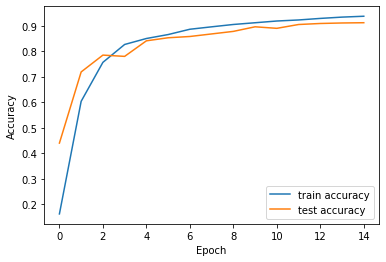


On train - best accuracy: 0.94, final accuracy: 0.94
On test - best accuracy: 0.91, final accuracy: 0.91


In [8]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();
best_train_acc = np.max(train_acc)
best_test_acc = np.max(test_acc)


print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))

In [ ]:
import sys
import os
# sys.path.append(os.path.abspath(os.getcwd()))
sys.path.append(os.path.abspath(os.getcwd() + "\\Desktop\\CIHW"))

%load_ext autoreload

%autoreload 2
from mytorch import Tensor, Model, Dependency
%autoreload 2
from mytorch import activation as active_func
%autoreload 2
from mytorch import loss as loss_func
%autoreload 2
from mytorch import optimizer as optim 
%autoreload 2
from mytorch import layer as nn
%autoreload 2
from mytorch.util import DataLoader
%autoreload 2
from mytorch.util import flatten

import numpy as np
import matplotlib.pyplot as plt

criterion = loss_func.CategoricalCrossEntropy

mp = nn.Conv2d(2, 2, (3, 3), (1, 1), (0, 0), need_bias=False, mode="one")
mp1 = nn.MaxPool2d(2, 2, (3, 3), (1, 1), (0, 0))
mp2 = nn.Conv2d(2, 2, (3, 3), (1, 1), (0, 0), need_bias=False, mode="one")
l = nn.Linear(32, 32, need_bias=False)
t1 = Tensor(np.array([[[
        [1, 1, 2, 1, 1]*2, 
        [1, 1, 2, 2, 1]*2, 
		[5, 1, 1, 3, 2]*2, 
		[2, 2, 1, 0, 1]*2, 
		[1, 2, 3, 1, 2]*2]*2]*2]*2), requires_grad=False)

print(t1.shape)
output = mp.forward(t1)
# print(output.shape)
output = active_func.relu(output) 
# print(output)
output = mp1.forward(output)
# print(output)
output = mp2.forward(output)
print(output.shape)
# print(output)
output = Tensor.reshape(output, (-1, 2 * 4 * 4))
# print(output)
output = l.forward(output)
# print(output)
output = active_func.softmax(output)
print(output.shape)
labels = np.zeros((2, 32))
labels[0, 4] = labels[1, 12] = 1
labels = Tensor(labels)
output = criterion(output, labels)
print("==================== final output")
print(output)
output.backward(Tensor(np.ones_like(output.data)))
wg = mp.weight.grad
print(wg)

